# Reviews-Based Yelp Award Project
# *Natural Language Processing*

**Alison Glazer**

This project is a conceptual idea for a new Yelp award that is driven by the content of a business's Yelp reviews. The initial prototype focuses on high-end restaurants in California, and the California Michelin Guide is used as a proxy for a judging criterion. 

This notebook contains the natural language processing done on the Yelp reviews. For each restaurant, all reviews are consolidated into a single document. The corpus is a collection of these documents for high-end restaurants in California.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Load-&amp;-Clean-Data" data-toc-modified-id="Load-&amp;-Clean-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load &amp; Clean Data</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Pre-Process-Text-Data" data-toc-modified-id="Pre-Process-Text-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pre-Process Text Data</a></span></li><li><span><a href="#Split-up-by-restaurants" data-toc-modified-id="Split-up-by-restaurants-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Split up by restaurants</a></span><ul class="toc-item"><li><span><a href="#LSA-on-restaurant-split" data-toc-modified-id="LSA-on-restaurant-split-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>LSA on restaurant split</a></span></li></ul></li><li><span><a href="#NMF-on-restaurant-split" data-toc-modified-id="NMF-on-restaurant-split-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>NMF on restaurant split</a></span></li><li><span><a href="#LDA-on-restaurant-split" data-toc-modified-id="LDA-on-restaurant-split-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>LDA on restaurant split</a></span></li><li><span><a href="#Topic-Modeling-on-Example-=-Bullion-from-Dallas,-TX" data-toc-modified-id="Topic-Modeling-on-Example-=-Bullion-from-Dallas,-TX-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Topic Modeling on Example = Bullion from Dallas, TX</a></span></li><li><span><a href="#SANDBOX" data-toc-modified-id="SANDBOX-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>SANDBOX</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#KMeans" data-toc-modified-id="KMeans-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>KMeans</a></span></li></ul></li><li><span><a href="#Clustering-with-KMeans" data-toc-modified-id="Clustering-with-KMeans-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Clustering with KMeans</a></span></li><li><span><a href="#Clustering-with-DBSCAN" data-toc-modified-id="Clustering-with-DBSCAN-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Clustering with DBSCAN</a></span></li></ul></div>

<a id="import_libraries"></a>
## Import Libraries

In [3]:
# Data
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Saving
import pickle

# Modeling / Clustering
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA
from itertools import cycle

# Text
import re
import string

import nltk
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.tokenize import MWETokenizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from gensim import corpora, models, similarities, matutils
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

# Logging for gensim (set to INFO)
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

<a id='load_data'></a>
## Load & Clean Data

Load the datasets containing labeled yelp reviews and associated metadata

In [4]:
import pickle

In [5]:
# Restaurant Data
with open('data/ca_restaurants.pkl','rb') as read_file:
    restaurants = pickle.load(read_file)

In [6]:
# Review Data
with open('data/ca_reviews.pkl','rb') as read_file:
    df = pickle.load(read_file)

In [7]:
# Group by restaurant and concatenate all reviews for each one
reviews_compiled = df.groupby('restaurantID')['reviewContent'].transform(lambda x: ' '.join(x))
reviews_compiled = pd.DataFrame([reviews_compiled,df.restaurantID]).transpose()

In [8]:
reviews_compiled = reviews_compiled.drop_duplicates()

In [9]:
del df

In [10]:
reviews_compiled.to_pickle('data/reviews_compiled.pkl')

In [11]:
# Reviews df
with open('data/reviews_compiled.pkl','rb') as read_file:
    reviews_compiled = pickle.load(read_file)

In [12]:
reviews_compiled.shape

(2371, 2)

In [13]:
reviews_compiled

,reviewContent,restaurantID
0,Nick's on Main has been my favorite South Bay ...,WUi5FGO9GllvkR83HEfMqw
1,The Church cocktail is pure summer cocktail pe...,43Ca7h2QxO6so8IvRk91FQ
2,One of the best meals I've had in a long long ...,6ZNlnA733Rv0I9Mq5_yO0A
3,Great Italian in Healdsberg Very yummy and a g...,vGTDBVj4m1-ZvtxgckUl2w
4,This is my go-to place for celebrating a speci...,Mk1expZCld__kiq_-t7K9g
...,...,...
15667,My cousin suggested this place since she's bee...,ATNT7TZFesc5E-JM9LzEpw
15675,"Never cared for Yankee Pier, but decided to gi...",qtsSpL-kFiN-lJ0NHPFtYg
15700,"A cozy, under-the-radar SF supperclub, run by ...",vt_5lTfNKZo7V0tun2VvJQ
15714,Date/Time: Â Monday - 8pm Occasion: Â Valentin...,7drBnDU03TSSaK2XO_-Frw


<a id="eda"></a>
## Exploratory Data Analysis

In [14]:
# Create new column for list of restaurant categories
restaurants['category_list'] = restaurants.categories.str.split(',')

In [15]:
# Create flat list of all restaurant categories
restaurant_categories = [category.strip(' ') for sublist in list(restaurants.category_list) for category in sublist]

restaurant_categories = [category for category in restaurant_categories if category != 'METADATA' and category != 'Restaurants']


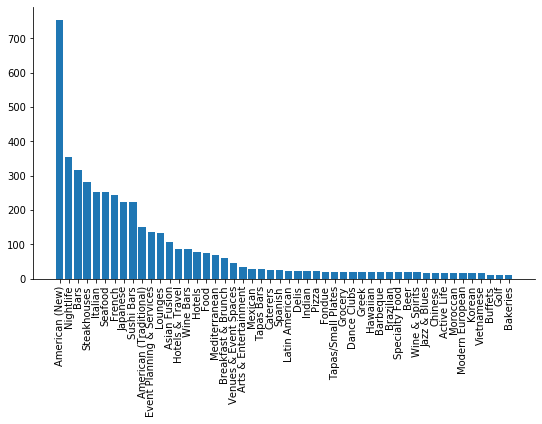

In [16]:
# Count occurences of each
category_counts = Counter(restaurant_categories).most_common()
# Look at the distribution
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:50]],
        [x[1] for x in category_counts[0:50]],
        width=0.8)
plt.xticks(rotation=90)
plt.title('')
sns.despine()

<a id="preprocess"></a>
## Pre-Process Text Data

In [17]:
def preprocess(docs):
    """
    Preprocess a corpus (Series) of documents before using a vectorizer
    - remove numbers and punctuation
    - remove urls
    - convert all text to lower case
    """
    # Remove numbers and punctuation
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    
    # Convert all text to lowercase
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    
    # Remove all image links
    image_link = lambda x: re.sub('http.*?¦',' ', x)
    
    return docs.map(alphanumeric).map(punc_lower).map(image_link)

In [18]:
restaurant_names = list(preprocess(restaurants.name))

In [90]:
stemmer=nltk.SnowballStemmer("english", ignore_stopwords=True)

def stem_tokens(tokens,stemmer):
    '''
    Stem word tokens using the English SnowballStemmer
    '''
    stemmed=[]
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    stemmed=[w for w in stemmed if len(w) > 3]
    return stemmed

# Stop words
stop_words_pre = ['michael mina','restaurant','yank sing','santa monica','just','ve','come','came','really','realli','restaurant','restaur','san francisco','california','michelin','michelin star','gary','danko','gary danko','french laundry','french laundri','jose andres','jose','slanted door','ferry building','los angeles','thomas keller','ruth chris','ruths chris',"ruth/'s chris'",'foreign cinema','santa','monica','santa monica','ruth chris','ruth','ruths chris','ritz carlton','ritz','carlton','yank',
                    'yank sing','slant door','slanted door','kokkari','bazaar','french laundry','french laundri','michael mina',
                    'angelini osteria', 'laundry','laundri','dish','door','slant','slanted','place','zuni','pretty','pretti','keller','mina',
                  'michael','nice','star','gordon','ramsay','chez','sotto','tsar','josi','jeanti','yountvill','crenn','bouchon','natasha','oishii',
                  'buttah','raymond','huntington','secretari','walnut','downtown','creek','madeo','baldi','riversid','riverside',
                  'bastilla','nozawa','culver','sofa','bonnet','safeway','jacqueline','jaqueline','quan','nhau','alsatian','germani',
                  'jacquelin','firehous','firehouse','christin','chris','christine','marriott', 'does','girlfriend'
                   ]
stop_words = stem_tokens(list(preprocess(pd.Series(stop_words_pre))),nltk.SnowballStemmer("english", ignore_stopwords=True))

In [91]:
def tokenize_and_stem(text):
    '''
    Tokenize and stem text
    '''
    tokens=nltk.word_tokenize(text)
    
    mwe_tokenizer = MWETokenizer(mwes=[('hotel','room'),('small','plate'),('small','plates'),('garlic','noodles'),
                                  ('garlic','noodle'),('bloodi','mari'),('lamb','chop'),('creamed','corn'),
                                  ('creamed','spinach'),('cream','corn'),('cream','spinach'),('crab','cake'),
                                  ('hand','roll'),('chocolate','cake'),('duck','confit'),('brussels','sprouts'),
                                  ('brussel','sprout'),('miso','soup'),('black','truffle'),('black','truffl'),
                                  ('deep','dish'),('chicago','style'),('spacca','napoli'),('pork','belly'),
                                  ('foie','gras'),('tasting','menu'),('restaurant','week'),('cotton','candy'),
                                  ('foie','gras'),('maine','lobster'),('maine','lobster'),('wagyu','beef'),
                                  ('philly','cheesesteak'),('chocolate','souffle'),('squash','blossom'),
                                  ('imperial','roll'),('goat','cheese'),('french','onion','soup'),
                                  ('spring','roll'),('pork','chop'),('bone','marrow'),('steak','tartar'),
                                  ('kobe','beef'),('tuna','tartar'),('crispy','rice'),('panna','cotta'),
                                  ('roast','chicken'),('happy','hour'),('spicy','tuna'),('medium','rare'),
                                  ('mashed','potatoes'),('mahi','mahi'),('filet','mignon'),('blue','crab'),
                                  ('dungeness','crab'),('clam','chowder'),('tikka','masala'),('gluten','free'),
                                  ('creme','brulee'),('whipped','cream'),
                                 ('good','food'),('good','service'),('good','view'),('dining','room'),
                                  ('dine','room'),('fresh','fish'),('amus','bouch'),('amuse','bouche'),
                                  ('baked','potato'),('chocolate','fondue'),('cheese','fondue'),
                                  ('great','service'),('great','food'),('italian','food'),('indian','food'),
                                    ('shabu','shabu'),('tomato','sauce'),('awesome','food'),('horrible','food')
                                 ])
    tokens = mwe_tokenizer.tokenize(tokens)
    
    #Alphabetical tokens only with word length greater than 3
    tokens = [w for w in tokens if len(w) > 3]
    stems=stem_tokens(tokens,stemmer)
    return stems

# Stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(set(stop_words))

def countvec(docs,tokenizer=tokenize_and_stem,ngram_range=(2,3),stop_words=my_stop_words,min_df=0.03,max_df=0.85):
    """
    Generate document-term inputs for topic modeling with LSA and NMF(doc_term_mat) and LDA(corpus, id2word) using count-vectorizer
    ----
    Input: series of documents (strings)
    Output: Document-term matrix
    """
    count_vectorizer = CountVectorizer(tokenizer=tokenizer, ngram_range=ngram_range, stop_words=stop_words,min_df=min_df,max_df=max_df);
    count_vectorizer.fit(docs);
    
    # Create document-term matrix for use in LSA and NMF
    doc_term_mat = count_vectorizer.transform(docs)
    
    # Create inputs for LDA
    corpus = matutils.Sparse2Corpus(doc_term_mat.transpose())
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    
    return count_vectorizer, doc_term_mat, corpus, id2word

def tfidfvec(docs,tokenizer=tokenize_and_stem,ngram_range=(2,3),stop_words=my_stop_words,min_df=0.03,max_df=0.85):
    """
    Generate document-term inputs for topic modeling with LSA and NMF(doc_term_mat) and LDA(corpus, id2word) using tf-idf-vectorizer
    ----
    Input: series of documents (strings)
    Output: Document-term matrix
    """
    tf_vectorizer= TfidfVectorizer(tokenizer=tokenizer,ngram_range=ngram_range,stop_words=stop_words,min_df=min_df,max_df=max_df);
    tf_vectorizer.fit(docs);

    # Create document-term matrix for use in LSA and NMF
    doc_term_mat = tf_vectorizer.transform(docs)
    
    # Create inputs for LDA
    corpus = matutils.Sparse2Corpus(doc_term_mat.transpose())
    id2word = dict((v, k) for k, v in tf_vectorizer.vocabulary_.items())    

    return tf_vectorizer, doc_term_mat, corpus, id2word

In [21]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    Display topics and top associated words given a topic model
    """
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

Ignore reviews with less than 20 words

In [ ]:
pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()

In [ ]:
doc_word.shape

## Split up by restaurants
All positive reviews for a restaurant joined into a single document

In [84]:
# Count Vectorizer
vectorizer_count, doc_term_mat_count, corpus_count, id2word_count = countvec(preprocess(reviews_compiled.reviewContent),ngram_range=(2,3))


/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'andr', 'angel', 'angelini', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'build', 'chri', 'cinema', 'describ', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'ferri', 'fifti', 'foreign', 'forti', 'francisco', 'french', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'osteria', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thoma', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


KeyboardInterrupt: 

In [ ]:
pickle.dump(vectorizer_count, open("vectorizer_count.pickle", "wb"))
pickle.dump(doc_term_mat_count, open("doc_term_mat_count.pickle", "wb"))

In [104]:
# TF-IDF Vectorizer
vectorizer_tf, doc_term_mat_tf, corpus_tf, id2word_tf = tfidfvec(preprocess(reviews_compiled.reviewContent),ngram_range=(2,3))


/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'andr', 'angel', 'angelini', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'build', 'chri', 'cinema', 'describ', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'ferri', 'fifti', 'foreign', 'forti', 'francisco', 'french', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'osteria', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thoma', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
pickle.dump(vectorizer_tf, open("vectorizer_tf.pickle", "wb"))
pickle.dump(doc_term_mat_tf, open("doc_term_mat_tf.pickle", "wb"))

### LSA on restaurant split

In [65]:
lsa_c = TruncatedSVD(20)
doc_topic_lsa_c = lsa_c.fit_transform(doc_term_mat_count)
print('Explained Variance Ratio per topic:\n',lsa_c.explained_variance_ratio_)

topic_word = pd.DataFrame(lsa_c.components_.round(3),
             columns = vectorizer_count.get_feature_names())
display_topics(lsa_c, vectorizer_count.get_feature_names(), 10)

Explained Variance Ratio per topic:
 [0.18715454 0.04307303 0.01771682 0.015356   0.01372595 0.01323415
 0.01254704 0.01166639 0.01136608 0.0104113  0.00958493 0.00944344
 0.00878139 0.00854992 0.00795718 0.00776215 0.00747425 0.00728543
 0.00713868 0.00695331]

Topic  0
dine experi, food good, wine pair, wine list, tast like, feel like, fine dine, look like, servic good, cook perfect

Topic  1
wine pair, fine dine, cours meal, dine experi, special occas, duck breast, second cours, servic impecc, sear scallop, chees plate

Topic  2
dine experi, melt mouth, tast like, sushi chef, make reserv, cook perfect, cours meal, make sure, caramel onion, noth special

Topic  3
wine list, cours meal, duck breast, cook perfect, high recommend, wine select, great wine, melt mouth, chees plate, special occas

Topic  4
food good, cours meal, dine experi, servic great, caramel onion, sear scallop, special occas, duck breast, food great, bottl wine

Topic  5
make reserv, sushi chef, wine pair, melt mouth

In [66]:
lsa_c_feats = pd.DataFrame(reviews_compiled.restaurantID).reset_index().drop(labels='index',axis=1).merge(pd.DataFrame(doc_topic_lsa_c),right_index=True,left_index=True)
lsa_c_feats.to_pickle('data/lsa_c_feats4.pkl')

In [105]:
lsa_tf = TruncatedSVD(20)
doc_topic_lsa_t = lsa_tf.fit_transform(doc_term_mat_tf)
print('Explained Variance Ratio per topic:\n',lsa_tf.explained_variance_ratio_)

topic_word = pd.DataFrame(lsa_tf.components_.round(3),
             columns = vectorizer_tf.get_feature_names())
display_topics(lsa_tf, vectorizer_tf.get_feature_names(), 30)

Explained Variance Ratio per topic:
 [0.0176619  0.01125579 0.01013933 0.00861293 0.00851032 0.00789567
 0.00762669 0.00707403 0.00693808 0.00671974 0.0066812  0.00638296
 0.00636198 0.00615729 0.00607653 0.00593703 0.00570391 0.00568806
 0.00559737 0.00549115]

Topic  0
food good, wine list, look like, tast like, feel like, dine experi, servic good, cook perfect, high recommend, food servic, servic great, wine pair, main cours, fine dine, make sure, melt mouth, felt like, make reserv, perfect cook, glass wine, special occas, bottl wine, noth special, quit good, look forward, servic excel, good thing, reason price, wait staff, long time

Topic  1
sushi chef, good sushi, fish fresh, food good, make reserv, saturday night, melt mouth, look like, make sure, good order, noth special, peopl watch, servic good, loung area, tast good, everi time, friday night, good fresh, right away, wasn good, great time, thing menu, wait minut, peopl like, drink order, late night, read review, fresh delici,

In [68]:
lsa_t_feats = pd.DataFrame(reviews_compiled.restaurantID).reset_index().drop(labels='index',axis=1).merge(pd.DataFrame(doc_topic_lsa_t),right_index=True,left_index=True)
lsa_t_feats.to_pickle('data/lsa_t_feats4.pkl')

## NMF on restaurant split

In [69]:
nmf_c = NMF(20)
doc_topic_nmf_c = nmf_c.fit_transform(doc_term_mat_count)
# nmf_model.explained_variance_ratio_
topic_word = pd.DataFrame(nmf_c.components_.round(3),
             columns = vectorizer_count.get_feature_names())
display_topics(nmf_c, vectorizer_count.get_feature_names(), 10)


Topic  0
fine dine, special occas, main cours, felt like, creme fraich, cours meal, second cours, servic food, best meal, beauti present

Topic  1
wine pair, food servic, perfect cook, food wine, look like, good good, meyer lemon, didn feel, feel like, great meal

Topic  2
tast like, noth special, didn like, caramel onion, good flavor, flavor textur, favorit night, dark chocol, didn tast, chocol mouss

Topic  3
wine list, wine select, great wine, wine glass, glass wine, main cours, good wine, high recommend, food wine, tast good

Topic  4
food good, good great, good servic, overal food, servic great, didn like, bottl wine, dessert good, servic food, glass wine

Topic  5
make reserv, make sure, wait minut, high recommend, second time, reserv time, everi time, high expect, wait tabl, good time

Topic  6
cours meal, duck breast, special occas, caramel onion, cook perfect, sear scallop, wine list, tast like, fine dine, chees plate

Topic  7
dine experi, melt mouth, servic good, bottl wine

In [70]:
nmf_c_feats = pd.DataFrame(reviews_compiled.restaurantID).reset_index().drop(labels='index',axis=1).merge(pd.DataFrame(doc_topic_nmf_c),right_index=True,left_index=True)
nmf_c_feats.to_pickle('data/nmf_c_feats4.pkl')

In [94]:
nmf_t = NMF(20)
doc_topic_nmf_t = nmf_t.fit_transform(doc_term_mat_tf)
# nmf_model_tf = doc_topic
# nmf_model.explained_variance_ratio_
topic_word = pd.DataFrame(nmf_t.components_.round(3),
             columns = vectorizer_tf.get_feature_names())
display_topics(nmf_t, vectorizer_tf.get_feature_names(), 30)


Topic  0
flavor, good, dessert, sauc, like, cream, bread, sweet, chocol, crispi, chees, lamb, light, duck, perfect, pork, textur, green, tast, creami, roast, entre, serv, order, potato, littl, tender, rich, butter, salad

Topic  1
sushi, fish, omakas, sashimi, japanes, chef, toro, nigiri, fresh, sushi chef, rice, qualiti, good, piec, salmon, sake, yellowtail, like, japan, albacor, best, tuna, order, wasabi, hamachi, good sushi, ponzu, serv, snapper, tempura

Topic  2
danc, club, floor, night, like, music, peopl, girl, crowd, loung, line, friend, time, hollywood, parti, drink, venu, cool, entertain, area, drunk, play, bottl, cover, look, think, event, perform, know, upstair

Topic  3
steak, steakhous, filet, ribey, order, prime, good, medium_rar, cook, salad, hous, bone, potato, filet_mignon, perfect, mashed_potato, sauc, dessert, rare, bread, good steak, steak good, best, butter, medium, onion, order steak, special, cake, meal

Topic  4
cours, chef, foie_gra, tasting_menu, pair, meal,

In [72]:
nmf_t_feats = pd.DataFrame(reviews_compiled.restaurantID).reset_index().drop(labels='index',axis=1).merge(pd.DataFrame(doc_topic_nmf_t),right_index=True,left_index=True)
nmf_t_feats.to_pickle('data/nmf_t_feats4.pkl')

## LDA on restaurant split

In [74]:
from sklearn.decomposition import LatentDirichletAllocation

In [75]:
lda_c = LatentDirichletAllocation(n_components=20,max_iter=50)
doc_topic_lda_c = lda_c.fit_transform(doc_term_mat_count)

In [76]:
topic_word = pd.DataFrame(lda_c.components_.round(3),
             columns = vectorizer_count.get_feature_names())
display_topics(lda_c, vectorizer_count.get_feature_names(), 10)


Topic  0
sushi chef, melt mouth, good sushi, fish fresh, good fresh, fresh delici, didn know, high qualiti, noth special, felt like

Topic  1
crab cake, lobster bisqu, cook perfect, good steak, steak cook, food servic, steak good, tender juici, order steak, servic excel

Topic  2
look like, food good, food order, tast like, feel like, dine experi, make sure, good think, main cours, good time

Topic  3
outdoor patio, great view, food good, servic food, great atmospher, look like, servic great, servic slow, sweet potato, appet entre

Topic  4
special occas, feel like, make sure, love love, servic great, food delici, custom servic, high recommend, servic excel, make reserv

Topic  5
wine list, food good, bottl wine, outdoor seat, servic good, green bean, heat lamp, good wine, wine select, good food

Topic  6
beet salad, wine list, brussel sprout, reason price, look forward, bottl wine, heirloom tomato, creme fraich, chocol sauc, good thing

Topic  7
lamb chop, heirloom tomato, dine exper

In [77]:
doc_term_mat_tf.shape

(2371, 393)

In [78]:
lda_c_feats = pd.DataFrame(reviews_compiled.restaurantID).reset_index().drop(labels='index',axis=1).merge(pd.DataFrame(doc_topic_lda_c),right_index=True,left_index=True)
lda_c_feats.to_pickle('data/lda_c_feats4.pkl')

In [95]:
lda_t = LatentDirichletAllocation(n_components=20,max_iter=50)
doc_topic_lda_t = lda_t.fit_transform(doc_term_mat_tf)

In [96]:
topic_word = pd.DataFrame(lda_t.components_.round(3),
             columns = vectorizer_tf.get_feature_names())
display_topics(lda_t, vectorizer_tf.get_feature_names(), 30)


Topic  0
runni, fuck, seat right away, reflect, mouth water, indoor, saffron, itali, spaghetti, japan, miso_soup, omakas, nigiri, good sushi, sushi chef, good, toro, food, excel food, delici food, overr, custom servic, grand, atmospher great, italian_food, great_food, mile, fresh delici, good price, game

Topic  1
food alway, overpr, probabl, alway, food, runni, fuck, seat right away, reflect, mouth water, indoor, saffron, itali, spaghetti, japan, miso_soup, omakas, nigiri, good sushi, good, sushi chef, toro, delici food, excel food, fresh delici, grand, atmospher great, custom servic, overr, great_food

Topic  2
gorgeous, simpli, runni, fuck, seat right away, reflect, mouth water, indoor, saffron, itali, spaghetti, japan, miso_soup, omakas, nigiri, good sushi, sushi chef, good, excel food, food, toro, delici food, fresh delici, overr, grand, custom servic, atmospher great, italian_food, great_food, enjoy meal

Topic  3
runni, fuck, seat right away, reflect, mouth water, indoor, saffr

In [82]:
lda_t_feats = pd.DataFrame(reviews_compiled.restaurantID).reset_index().drop(labels='index',axis=1).merge(pd.DataFrame(doc_topic_lda_t),right_index=True,left_index=True)
lda_t_feats.to_pickle('data/lda_t_feats4.pkl')

## Topic Modeling on Example = Bullion from Dallas, TX
The work done below here is for an example used in the project presentation

In [101]:
bullion_reviews = txt = open("data/bullion_reviews.txt").read()

In [110]:
# Pre_Process
bullion_reviews_process = re.sub('\w*\d\w*', ' ', bullion_reviews)
bullion_reviews_process = re.sub('[%s]' % re.escape(string.punctuation), ' ', bullion_reviews_process.lower())
bullion_reviews_process = re.sub('http.*?¦',' ', bullion_reviews_process)
bullion_reviews_process = re.sub('\\n',' ',bullion_reviews_process)

In [116]:
# Transform on TF-IDF Vectorizer
doc_term_bullion = vectorizer_tf.transform(pd.Series(bullion_reviews_process))

In [117]:
# Get document-topic matrix with LSA
doc_topic_lsa_t_bullion = lsa_tf.transform(doc_term_bullion)


In [124]:
# These are the values to input into the test model
doc_topic_lsa_t_bullion[0]

array([ 0.55008134, -0.12656982,  0.04557796,  0.17393609, -0.02667111,
        0.0184407 , -0.18908966, -0.03081288, -0.05425768,  0.01228452,
        0.03264471,  0.00196892, -0.10826143, -0.03573562, -0.0605818 ,
        0.03982949, -0.07230415,  0.08661016, -0.01234881,  0.08003016])

<a id='sandbox'></a>
## SANDBOX
Everything below here is mostly unfinished

## Clustering
Try using clustering algorithms to see if the topic modeling yielded useful clusters of restaurants

In [39]:
def kmeans(feature_matrix,k=3):
    """
    K Means clustering with number of clusters = k
    """
    km_model=KMeans(n_clusters=k,random_state=42)
    km_model.fit(feature_matrix)
    return km_model

### KMeans

In [ ]:
feature_matrix = pd.DataFrame(nmf_pos_tf_tastingtapasprefix)
km_model = kmeans(feature_matrix)
cluster_labels = km_model.labels_.tolist()
cluster_df=pd.DataFrame(zip(list(docs_pos.index),list(docs_pos.values),cluster_labels),columns=["review_index","review","cluster_label"],index=cluster_labels)
feat_and_target = feature_matrix.copy()
feat_and_target['cluster_label'] = cluster_labels
# km_model.cluster_centers_

In [ ]:
# Test silhouette scores to confirm best number of clusters
k_range = range(2,16)
scores = []
for k in k_range:
    km_ss = kmeans(feature_matrix)
    scores.append(silhouette_score(feature_matrix, km_ss.labels_))

# plot the results
sns.mpl.pyplot.plot(k_range, scores)
sns.mpl.pyplot.xlabel('Number of clusters')
sns.mpl.pyplot.ylabel('Silhouette Coefficient')

In [ ]:
pd.DataFrame(nmf_pos_tf_tastingtapasprefix)

In [ ]:
# Use PCA to break down to 2 components to visualize
pca = PCA(n_components=2)
pca.fit(feature_matrix);
pca_features = pca.transform(feature_matrix)

In [ ]:
# Visualize clusters in pairplot
sns.pairplot(feat_and_target,hue='cluster_label')

## Clustering with KMeans

In [96]:
feature_matrix = pd.DataFrame(doc_topic_lsa_t)
km_model = kmeans(feature_matrix,k=4)
km_cluster_labels = km_model.labels_.tolist()
km_cluster_df=pd.DataFrame(zip(list(preprocess(reviews_compiled.reviewContent).index),list(preprocess(reviews_compiled.reviewContent).values),km_cluster_labels),columns=["restaurant_index","restaurant_reviews","cluster_label"],index=km_cluster_labels)
km_feat_and_target = feature_matrix.copy()
km_feat_and_target['cluster_label'] = km_cluster_labels
# km_model.cluster_centers_

## Clustering with DBSCAN

In [125]:
db = DBSCAN(eps=0.25, min_samples=3)
db_model = db.fit(feature_matrix)
db_cluster_labels = db_model.labels_.tolist()
db_cluster_df=pd.DataFrame(zip(list(preprocess(reviews_compiled.reviewContent).index),list(preprocess(reviews_compiled.reviewContent).values),db_cluster_labels),columns=["restaurant_index","restaurant_reviews","cluster_label"],index=db_cluster_labels)
db_feat_and_target = feature_matrix.copy()
db_feat_and_target['cluster_label'] = db_cluster_labels
# km_model.cluster_centers_

In [126]:
db_cluster_df.cluster_label.value_counts()

 0     1879
 1      102
-1       96
 3       88
 6       78
 7       29
 2       29
 8       28
 4       24
 9        5
 5        4
 11       3
 12       3
 10       3
Name: cluster_label, dtype: int64

- PCA to get topics down to fewer (what about just picking a few topics??)
- add in other data about reviews and restaurants for more columns

In [99]:
from mpl_toolkits import mplot3d

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


# Create a plot of the PCA results
def plot_PCA_3D(data, target, target_names):
    colors = cycle(['r','g','b','m','y','orange','w','aqua','yellow'])
    cmap = get_cmap(len(target_names))
    target_ids = range(len(target_names))
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes(projection='3d')
    for i, label in zip(target_ids, target_names):
        ax.scatter3D(data[target == i, 0], data[target == i, 1], data[target == i, 2],
                    label=label, edgecolors='gray',alpha=0.3)
    plt.legend()

In [100]:
# Use PCA to break down to 2 components to visualize
pca = PCA(n_components=3)
pca.fit(feature_matrix);
pca_features = pca.transform(feature_matrix)

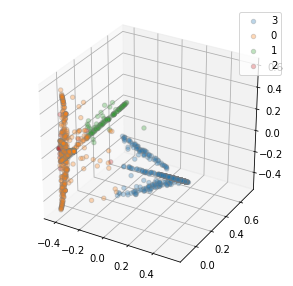

In [121]:
plot_PCA_3D(pca_features, target=km_cluster_df.cluster_label, target_names=km_cluster_df.cluster_label.unique())

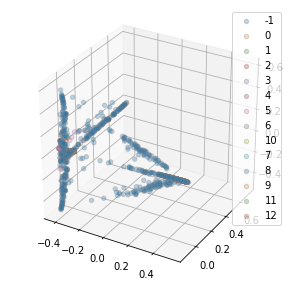

In [127]:
plot_PCA_3D(pca_features, target=db_cluster_df.cluster_label, target_names=db_cluster_df.cluster_label.unique())

In [104]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow','pink','purple','lightblue'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        print(i,c,label)
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

0 r 3
1 g 0
2 b 1
3 c 2


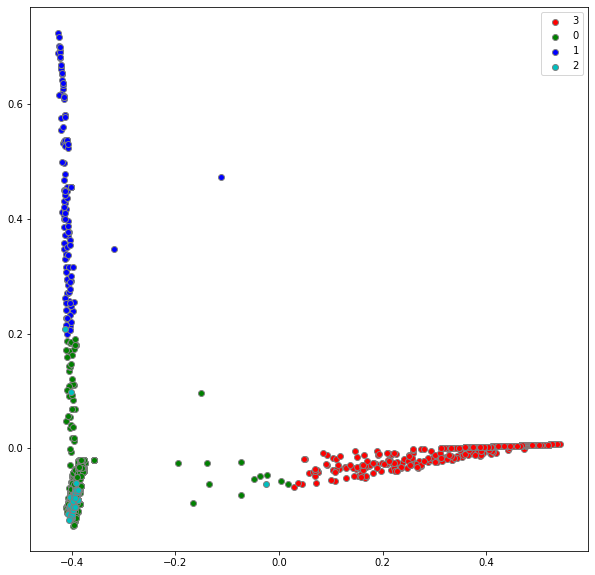

In [106]:
plot_PCA_2D(pca_features, target=km_cluster_df.cluster_label, target_names=km_cluster_df.cluster_label.unique())
